# Initial Operations:

In [1]:
import pandas as pd
import os
import numpy as np


from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV

import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [2]:
path = '/Users/andrew/school_assignments/LMPM/full_combined_datasets/'
filename = 'combined_yeast_UniRep_dataset.pkl'
data = pd.read_pickle(path+filename)

### Define dependent (localization labels) and independent variables (UniReps), then do a randomized 80:20 split of inputs into training and testing datasets

In [3]:
y = data.location.to_numpy()
X = np.stack(data["UniRep"].to_numpy())

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# Supervised-learning method comparison

### Ridge-regression classifier

In [4]:
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.857389801210026


### KNN classifier

In [5]:
K_neighbors = int(np.sqrt(len(y_train))) # set number of neigbors to square root of number of inputs
clf = KNeighborsClassifier(K_neighbors, weights='uniform')
clf.fit(X_train, y_train)
mean_accuracy = clf.score(X_test, y_test)
print(mean_accuracy)


0.7878133102852204


### Conclusions from classifier model comparison:
* Overall, we see that the ridge-regression outperforms K-nearest-neighbors for classification.
* I tested 3 other linear classifier models from sklearn, but none performed very well, so not worth including here.
* The dataset is imbalanced, largely due to the crazy amount of membrane proteins in eukaryotes.  Separate tests where we only classify if a protein is secreted vs cytoplasm-localized perform amazingly (~ 90% accuracy!!!), so the membrane proteins are really the ones causing trouble.
* I think our dataset is large enough for deep-learning to start achieving performance improvements over linear models
* Does anybody want to try whipping up a quick perceptron-type neural network (a generic MNIST-classifier tutorial type of model would probably work here) and see if we can beat the ridge-regression score?  



.

# Unsupervised-learning: the search for implicit meaning within arbitrary sequence features

### Principal Component Analysis:

#### Mnimum number of components to retain >= 90% explained variance per principal component

Number of compnents needed:  57


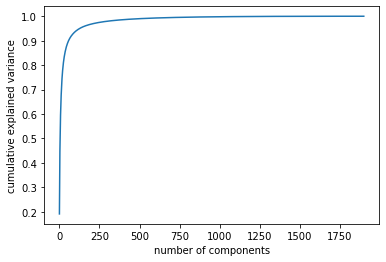

In [6]:
pca = PCA().fit(X)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

N_COMPS = np.where(explained_variance>=0.9)[0][0]
print('Number of compnents needed: ',N_COMPS)

#### Making a plot of the first 3 principal components following dimension-reduction, colored by localization label

<Figure size 432x288 with 0 Axes>

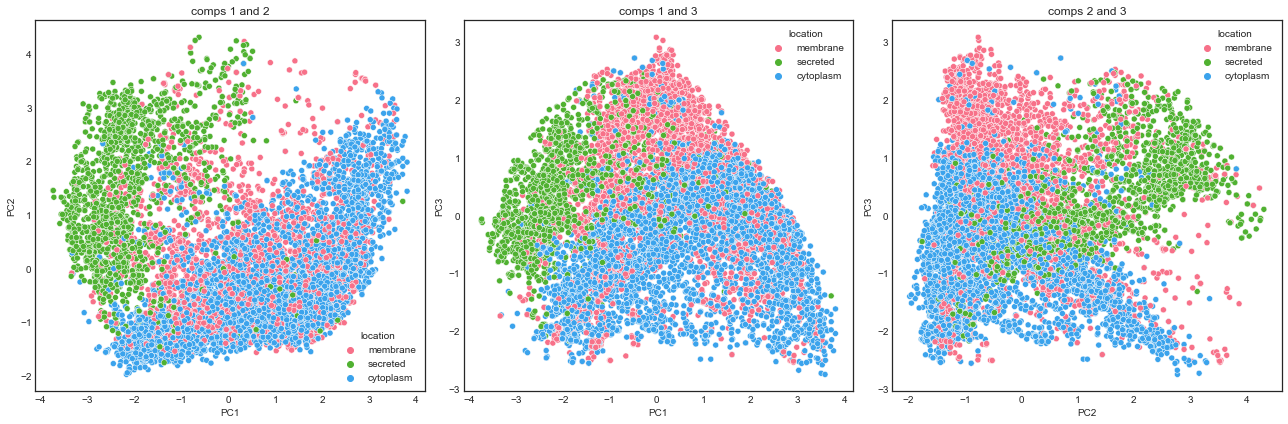

In [7]:
label_df = data['location']
pca_labels = ['PC'+str(i+1) for i in range(N_COMPS)]

pca = PCA(n_components=N_COMPS)
pca_result = pca.fit_transform(X)

pca_df = pd.concat([pd.DataFrame(data.location.values, columns=['location']),pd.DataFrame(pca_result, columns=pca_labels)],axis=1)



colors = {'secreted':'springgreen', 'cytoplasm':'deepskyblue', 'membrane':'violet'}


plt.clf()
fig = plt.figure(figsize=(18,6))
plt.style.use('seaborn-white')

ax1 = fig.add_subplot(1,3,1, title="comps 1 and 2")
sns.scatterplot(x="PC1", y="PC2",hue="location",palette=sns.color_palette("husl", 3),data=pca_df,legend="brief",ax=ax1)

ax2 = fig.add_subplot(1,3,2, title="comps 1 and 3")
sns.scatterplot(x="PC1", y="PC3",hue="location",palette=sns.color_palette("husl", 3),data=pca_df,legend="brief",ax=ax2)


ax3 = fig.add_subplot(1,3,3, title="comps 2 and 3")
sns.scatterplot(x="PC2", y="PC3",hue="location",palette=sns.color_palette("husl", 3),data=pca_df,legend="brief",ax=ax3)


plt.tight_layout()
plt.show()

### t-SNE: because we can take this even further

#### Performing that t-distributed stochastic neighbor embedding computation on our dimension-reduced PCA data

In [8]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

tsne_df = pd.DataFrame(data.location.values, columns=['location'])

tsne_df['tsne-2d-1'] = tsne_results[:,0]
tsne_df['tsne-2d-2'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11568 samples in 0.001s...
[t-SNE] Computed neighbors for 11568 samples in 3.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11568
[t-SNE] Computed conditional probabilities for sample 2000 / 11568
[t-SNE] Computed conditional probabilities for sample 3000 / 11568
[t-SNE] Computed conditional probabilities for sample 4000 / 11568
[t-SNE] Computed conditional probabilities for sample 5000 / 11568
[t-SNE] Computed conditional probabilities for sample 6000 / 11568
[t-SNE] Computed conditional probabilities for sample 7000 / 11568
[t-SNE] Computed conditional probabilities for sample 8000 / 11568
[t-SNE] Computed conditional probabilities for sample 9000 / 11568
[t-SNE] Computed conditional probabilities for sample 10000 / 11568
[t-SNE] Computed conditional probabilities for sample 11000 / 11568
[t-SNE] Computed conditional probabilities for sample 11568 / 11568
[t-SNE] Mean sigma: 0.671040
[t-SNE] KL divergenc

#### Plotting some dank feature separations from the t-SNE

<Figure size 432x288 with 0 Axes>

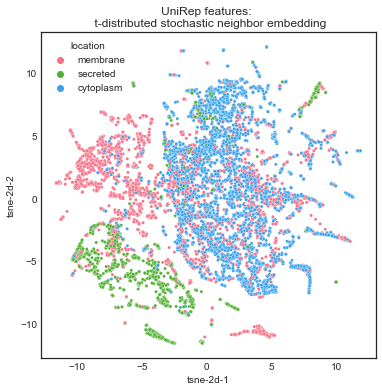

In [9]:
plt.clf()
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(1,1,1, title="UniRep features: \n t-distributed stochastic neighbor embedding")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="location",
    palette=sns.color_palette("husl", 3),
    data=tsne_df,
    legend="brief",
    s=10,
    ax=ax1
)

### Conclusions from classifier model comparison:
* There are implicit feature differences between cytoplasmic and secreted proteins.
* It's just those darn membrane proteins causing problems again.
* can we minimize this somehow?


.